In [1]:
import os
from dotenv import load_dotenv
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

load_dotenv(override=True)

DATA_PATH = os.getenv('DATA_PATH')
print(DATA_PATH)

# Choose subontology (CCO, MFO or BPO)
SO = 'BPO'

2023-06-08 08:37:07.865734: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 08:37:08.293871: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1
/mnt/e/ML/cafa-5-protein-function-prediction


2023-06-08 08:37:08.834055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-08 08:37:08.850406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-08 08:37:08.850726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.


## Reading fasta, obo and tsv files

In [2]:
from Bio import SeqIO

sequences = [rec.seq for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]
ids = [rec.id for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]

In [3]:
import networkx
import obonet

# Read the taxrank ontology
url = os.path.join(DATA_PATH, "Train/go-basic.obo")
graph = obonet.read_obo(url)



In [4]:
df = pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

dfSO = df.loc[df["aspect"]==SO]
uniqueTerms = dfSO["term"].unique()
termsArr = list(dfSO["term"].to_numpy())

uniqueTermsDict={}
for i,el in enumerate(uniqueTerms):
    uniqueTermsDict[el] = i
    
print(dfSO.shape)
df=dfSO

df.set_index("EntryID", inplace=True)

(3497732, 3)


In [5]:
testID = df.index.to_list()[0]

## GO analysis

In [6]:
item_counts = df["term"].value_counts()

In [7]:
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

## Label encoding

The task is a multilabel classification: The output has several possible targets (Gene Ontologies) but each can only be 1 (existing) or 0 (non existing)

Extract label weights from IA

In [8]:
dfIa = pd.read_csv(os.path.join(DATA_PATH, "IA.txt"), sep='\t', header=None)

dfIa.set_index(0, inplace=True)

labelWeights=[]
allIndices = dfIa.index.tolist()


for go in item_counts.index.to_list():
    if go in allIndices:
        labelWeights.append(dfIa.loc[go].to_numpy()[0])
    else:
        labelWeights.append(1)

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
import pickle

topGOs= item_counts
topGOs=topGOs.index.to_list()

mlb = MultiLabelBinarizer()
mlb.fit([topGOs])

dftest=df.loc[testID]
indices = dftest["term"].to_numpy()
print(indices)
print(mlb.transform([indices]))
print(len(mlb.classes_))

with open(os.path.join(DATA_PATH,'MLB_'+SO+'.pkl'), 'wb') as f:
    pickle.dump(mlb, f)

['GO:0008152' 'GO:0034655' 'GO:0072523' 'GO:0044270' 'GO:0006753'
 'GO:1901292' 'GO:0044237' 'GO:1901360' 'GO:0008150' 'GO:1901564'
 'GO:1901565' 'GO:0009117' 'GO:0006139' 'GO:0044281' 'GO:0046496'
 'GO:0019362' 'GO:0046483' 'GO:0055086' 'GO:0044248' 'GO:0019439'
 'GO:0019637' 'GO:0006807' 'GO:0019677' 'GO:1901361' 'GO:0006163'
 'GO:0046700' 'GO:0009987' 'GO:0006725' 'GO:0006796' 'GO:0034641'
 'GO:0072521' 'GO:0071704' 'GO:0019364' 'GO:1901575' 'GO:0072526'
 'GO:0046434' 'GO:0009166' 'GO:0072524' 'GO:0006195' 'GO:0009056'
 'GO:0044238' 'GO:0006793' 'GO:0019674']
[[0 0 0 ... 0 0 0]]
21285


## Amino acids encoding

In [10]:
aminos_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'X']

In [11]:
aa_dict = {'A': 1, 'B':24, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 21, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'U': 22, 'V': 18, 'W': 19, 'Y': 20, 'X':30, 'Z':23}

## Build Dataset

In [12]:
seqLengths = [len(seq) for seq in sequences]
maxLen = max(seqLengths)
print("The max. length of the sequences is {}".format(maxLen))

The max. length of the sequences is 35375


In [13]:

dfAll=pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

soEntries = dfAll.loc[dfAll["aspect"]==SO]
soEntryIds = soEntries["EntryID"].unique()

# print(len(seqEntries))
print(soEntryIds)

SoSequences = []
for entry in soEntryIds:
    SoSequences.append(sequences[ids.index(entry)])

print(len(SoSequences))
dfAll.set_index("EntryID", inplace=True)

['A0A009IHW8' 'A0A021WW32' 'A0A023FFD0' ... 'X5L1L5' 'X5L565' 'X5M5N0']
92210


In [14]:
import warnings
from itertools import product
from tqdm import tqdm
import os

TRAIN_VAL_SPLIT = 0.7
k = 3

allAA = list(aa_dict.keys())
allAA.sort()
allCombinations= list(product(*(allAA for i in range(k))))
allCombinations=np.array([''.join(el) for el in allCombinations])

positionDict = dict(zip(allCombinations, np.arange(0,allCombinations.size).T))

#Use numpy vectorize to speed up the mapping (hopefully)
mapping = lambda x: aa_dict[x]
vectMapping = np.vectorize(mapping)

# Shuffle the data
import random
random.seed(516213)
c = list(zip(sequences, ids))
random.shuffle(c)
sequencesShuffle, idsShuffle = zip(*c)


#Train Validation Split
split = int(np.floor(len(sequencesShuffle)*TRAIN_VAL_SPLIT))
print(split)
trainSeq = sequencesShuffle[0:split]
valSeq = sequencesShuffle[split+1:]
trainIds = idsShuffle[0:split]
valIds = idsShuffle[split+1:]


def generator():
  for i,seq in enumerate(trainSeq):
      entryId = trainIds[i]
      
      if entryId in soEntryIds:
        labelData = df.loc[entryId]
        # indices = labelData["termToken"].to_numpy()
        indices = labelData["term"].to_numpy()
      else:
        indices=[]

      with warnings.catch_warnings():
          #supress the warnings for unknown classes
          warnings.simplefilter("ignore")
          y = mlb.transform([indices])
      
      
      kmers = [seq[i:i+k] if i < len(seq)-(k-1) else 0 for i,el in enumerate(seq)]
      kmers = kmers[0:-(k-1)]
      kmers = [str(el) for el in kmers]
      values, counts = np.unique(kmers, return_counts=True)
      freqVector=np.zeros(allCombinations.shape)
      for j,v in enumerate(values):
          freqVector[positionDict[v]] = counts[j]
      yield (freqVector,y[0])


def generatorVal():
  for i,seq in enumerate(valSeq):
      entryId = valIds[i]
      if entryId in soEntryIds:
        labelData = df.loc[entryId]
        # indices = labelData["termToken"].to_numpy()
        indices = labelData["term"].to_numpy()
      else:
        indices=[]

      with warnings.catch_warnings():
          #supress the warnings for unknown classes
          warnings.simplefilter("ignore")
          y = mlb.transform([indices])
      
      kmers = [seq[i:i+k] if i < len(seq)-(k-1) else 0 for i,el in enumerate(seq)]
      kmers = kmers[0:-(k-1)]
      kmers = [str(el) for el in kmers]
      values, counts = np.unique(kmers, return_counts=True)
      freqVector=np.zeros(allCombinations.shape)
      for j,v in enumerate(values):
          freqVector[positionDict[v]] = counts[j]
      yield (freqVector,y[0])
        

99572


In [15]:
g = generator()
test = next(g)
print("The first sample: {}".format(test[0].shape))
print("The first sample has {} classes".format(np.count_nonzero(test[1])))

The first sample: (15625,)
The first sample has 0 classes


## Tensorflow Classification

In [16]:
import tensorflow as tf

xSize = allCombinations.shape[0]

dataset = tf.data.Dataset.from_generator(generator, output_signature=(
         tf.TensorSpec(shape=(xSize,), dtype=tf.int32),
         tf.TensorSpec(shape=(len(mlb.classes_),), dtype=tf.int32)))
print(list(dataset.take(1)))

datasetVal = tf.data.Dataset.from_generator(generatorVal, output_signature=(
         tf.TensorSpec(shape=(None,), dtype=tf.int32),
         tf.TensorSpec(shape=(len(mlb.classes_),), dtype=tf.int32)))

[(<tf.Tensor: shape=(15625,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>, <tf.Tensor: shape=(21285,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)]


2023-06-08 08:38:12.962279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-08 08:38:12.962663: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-08 08:38:12.963006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-08 08:38:13.390287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-08 08:38:13.390623: I tensorflow/compile

In [17]:
%load_ext tensorboard


In [18]:
from tensorflow.keras import layers

VOCAB_SIZE=len(aa_dict)
EMBED_DIM=100

def createModel():
    inputs = tf.keras.Input(shape=(xSize,))
    # x=layers.Embedding(VOCAB_SIZE, EMBED_DIM, name="embedding")(inputs)

    x=layers.Conv1D(8, 7, activation=tf.keras.activations.relu)(tf.expand_dims(inputs,2))
    x=layers.Conv1D(8, 7, activation=tf.keras.activations.relu)(x)
    x=layers.Conv1D(8, 7, activation=tf.keras.activations.relu)(x)
    x=layers.Conv1D(16, 7, activation=tf.keras.activations.relu)(x)
    x=layers.Conv1D(16, 7, activation=tf.keras.activations.relu)(x)
    x=layers.Conv1D(16, 7,strides=2, activation=tf.keras.activations.relu)(x)
    x=layers.Conv1D(16, 7,strides=2, activation=tf.keras.activations.relu)(x)
    x=layers.Conv1D(16, 7,strides=2, activation=tf.keras.activations.relu)(x)

    # x=layers.Conv1D(32, 5, activation=tf.keras.activations.relu)(x)
    # x=layers.Conv1D(32, 5, activation=tf.keras.activations.relu)(x)
    # x=layers.Conv1D(32, 5, activation=tf.keras.activations.relu)(x)
    x=layers.Flatten()(x)
    x=layers.Dense(64)(x)
    x=layers.LeakyReLU()(x)
    x=layers.Dense(64)(x)
    x=layers.LeakyReLU()(x)
    outputs=layers.Dense(len(mlb.classes_), activation=tf.keras.activations.sigmoid)(x)
    # outputs=layers.Softmax()(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="embedConvModel")

model = createModel()

model.summary()


Model: "embedConvModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15625)]           0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 15625, 1)         0         
                                                                 
 conv1d (Conv1D)             (None, 15619, 8)          64        
                                                                 
 conv1d_1 (Conv1D)           (None, 15613, 8)          456       
                                                                 
 conv1d_2 (Conv1D)           (None, 15607, 8)          456       
                                                                 
 conv1d_3 (Conv1D)           (None, 15601, 16)         912       
                                                                 
 conv1d_4 (Conv1D)           (None, 15595, 16)      

In [19]:

VOCAB_SIZE=len(aa_dict)
EMBED_DIM=500
OUT_SEQ_LENGTH=10

def createRnnModel():
    inputs = tf.keras.Input(shape=(TRUNCATE,))
    # x = tf.keras.layers.Masking(0)(inputs)
    x=layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True, name="embedding")(inputs)

    # x = layers.RepeatVector(OUT_SEQ_LENGTH)(x)

    x = layers.Bidirectional(layers.LSTM(200, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(200))(x)
    # x = layers.LSTM(64)(x)
    x = layers.Dense(500)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dense(500)(x)
    outputs=layers.Dense(len(mlb.classes_), activation=tf.keras.activations.sigmoid)(x)
    # outputs=layers.Softmax()(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="embedRnnModel")

# model = createRnnModel()

# model.summary()

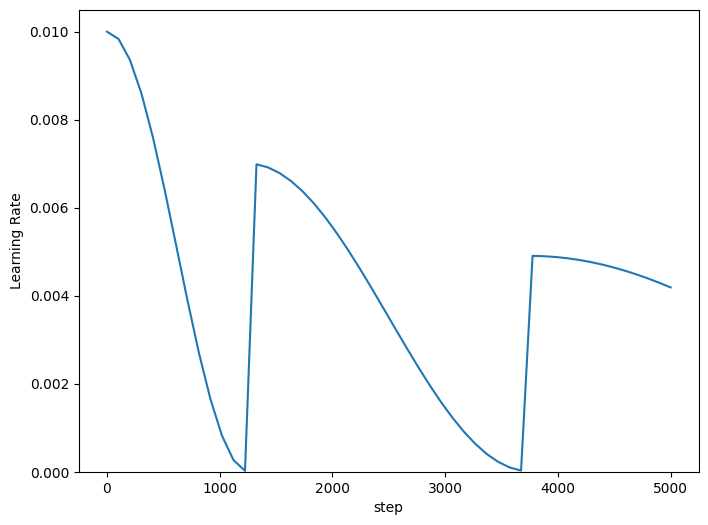

In [20]:
import matplotlib.pyplot as plt
#Learning rate schedule
initial_learning_rate = 0.01
decaySteps=5000
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate, first_decay_steps=decaySteps/4,
                                                                t_mul=2.0, m_mul=0.7, alpha=0.001)
# lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate, decay_steps=decaySteps, alpha=0.01)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,decay_steps=decaySteps,decay_rate=0.9,staircase=False)
step = np.linspace(0,decaySteps)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
# plt.yscale("log")
plt.plot(step, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('step')
_ = plt.ylabel('Learning Rate')

In [21]:
from tensorflow.keras.losses import Loss

class WeightedBinaryCE(Loss):
    # initialize instance attributes
    def __init__(self, classWeights, labelSmoothing=0.0):
        super(WeightedBinaryCE, self).__init__()
        self.labelSmoothing = tf.constant(labelSmoothing, dtype=tf.dtypes.float32)
        self.classWeights= tf.constant(classWeights, dtype=tf.dtypes.float32)
        
    # Compute loss
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        if(self.labelSmoothing>0):
            y_true = y_true*(1-self.labelSmoothing)+self.labelSmoothing/2
        y_pred = tf.cast(y_pred, tf.float32)
        y_pred = tf.clip_by_value(y_pred,tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        term_0 = tf.math.multiply(self.classWeights * tf.math.subtract(1.0 , y_true), tf.math.log(tf.math.subtract(1.0, y_pred) + tf.keras.backend.epsilon()))
        term_1 = tf.math.multiply(self.classWeights * y_true, tf.math.log(y_pred + tf.keras.backend.epsilon()))
        losses = term_0 + term_1
        return -tf.reduce_mean(losses, axis=0)
    

testLoss = WeightedBinaryCE([1,1,1])
labelsTrue = tf.constant([[1,0,1], [1,1,0]])
labelsPred = tf.constant([[0.42,0.111,0.957], [0.877,0.121,0.544]])

print(testLoss(labelsTrue, labelsPred))
kerasCE = tf.keras.losses.BinaryCrossentropy()
print(kerasCE(labelsTrue, labelsPred))


tf.Tensor(0.6762641, shape=(), dtype=float32)
tf.Tensor(0.6762641, shape=(), dtype=float32)


In [22]:


class DiceLoss(Loss):
    # initialize instance attributes
    def __init__(self):
        super(DiceLoss, self).__init__()
        
    # Compute loss
    def call(self, y_true, y_pred, smooth=1e-6):
      inputs = tf.squeeze(tf.cast(y_pred, tf.dtypes.float32))
      targets = tf.squeeze(tf.cast(y_true, tf.dtypes.float32))
    
      intersection = tf.math.reduce_sum(tf.math.multiply(targets, inputs))
      dice = (2*intersection + smooth) / (tf.math.reduce_sum(targets) + tf.math.reduce_sum(inputs) + smooth)
      return 1 - dice
    

testLoss = DiceLoss()
labelsTrue = tf.constant([[1,0,1], [1,1,0]])
labelsPred = tf.constant([[0.9,0.01,0.957], [0.877,0.921,0.1]])

print(testLoss(labelsTrue, labelsPred))


tf.Tensor(0.058596253, shape=(), dtype=float32)


In [23]:


# α controls the amount of Dice term contribution in the loss f
# β ∈ [0, 1] controls the level of model penalization for false positives/negatives: when β is set to
# a value smaller than 0.5, FP are penalized more than FN


class WeightedComboLoss(Loss):
    # initialize instance attributes
    def __init__(self, labelWeights, alpha=0.5, beta=0.5):
        super(WeightedComboLoss, self).__init__()
        self.classWeights = tf.constant(labelWeights, dtype=tf.dtypes.float32)
        self.alpha=tf.constant(alpha, dtype=tf.dtypes.float32)
        self.beta=tf.constant(beta, dtype=tf.dtypes.float32)
        
    # Compute loss
    def call(self, y_true, y_pred, smooth=1e-6):
      inputs = tf.squeeze(tf.cast(y_pred, tf.dtypes.float32))
      targets = tf.squeeze(tf.cast(y_true, tf.dtypes.float32))
    
      intersection = tf.math.reduce_sum(tf.math.multiply(targets, inputs))
      dice = (2*intersection + smooth) / (tf.math.reduce_sum(targets) + tf.math.reduce_sum(inputs) + smooth)
     
      y_true = tf.cast(y_true, tf.float32)
      y_pred = tf.cast(y_pred, tf.float32)
      y_pred = tf.clip_by_value(y_pred,tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
      term_0 = tf.math.multiply((1-self.beta) * self.classWeights * tf.math.subtract(1.0 , y_true), tf.math.log(tf.math.subtract(1.0, y_pred) + tf.keras.backend.epsilon()))
      term_1 = tf.math.multiply(self.beta * self.classWeights * y_true, tf.math.log(y_pred + tf.keras.backend.epsilon()))
      losses = term_0 + term_1
      weightedCE = -tf.reduce_mean(losses, axis=0)

      combo = (self.alpha * weightedCE) - ((1 - self.alpha) * dice)

      return combo
    

testLoss = WeightedComboLoss([1,1,1])
labelsTrue = tf.constant([[1,0,1], [1,1,0]])
labelsPred = tf.constant([[0.9,0.1,0.9], [0.8,0.9,0.05]])

print(testLoss(labelsTrue, labelsPred))


tf.Tensor(-0.4285214, shape=(), dtype=float32)


In [24]:


class WeightedF1(tf.keras.metrics.Metric):
    def __init__(self, classWeights, threshold=0.5):
        super(WeightedF1, self).__init__()
        self.classWeights= tf.constant(classWeights, dtype=tf.dtypes.float32)
        self.threshold= tf.constant(threshold, dtype=tf.dtypes.float32)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.total = self.add_weight('total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        m = tf.math.count_nonzero(tf.reduce_min(y_pred, axis=1))
        n = tf.shape(y_pred)[0]
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.math.greater_equal(y_pred,self.threshold)
   

        tp = tf.math.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
        tp = tf.cast(tp, self.dtype)
        tp = tf.math.multiply(tp, self.classWeights)
        tp = tf.cast(tp, self.dtype)

        tn = tf.math.logical_and(tf.equal(y_true, False), tf.equal(y_pred, False))
        tn = tf.cast(tn, self.dtype)
        tn = tf.math.multiply(tn, self.classWeights)
        tn = tf.cast(tn, self.dtype)

        fp = tf.math.logical_and(tf.equal(y_true, True), tf.equal(y_pred, False))
        fp = tf.cast(fp, self.dtype)
        fp = tf.math.multiply(fp, self.classWeights)
        fp = tf.cast(fp, self.dtype)

        fn = tf.math.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True))
        fn = tf.cast(fn, self.dtype)
        fn = tf.math.multiply(fn, self.classWeights)
        fn = tf.cast(fn, self.dtype)

        pr = tf.math.divide(tf.math.reduce_sum(tp, axis=1),tf.math.reduce_sum(tp+fp+tf.keras.backend.epsilon(), axis=1))
        m = tf.cast(m, pr.dtype)
        if(m>0):
            wPr = tf.math.reduce_sum(pr)/m
        else:
            wPr = tf.constant(0, tf.dtypes.float32)

        re = tf.math.divide(tf.math.reduce_sum(tp, axis=1),tf.math.reduce_sum(tp+fn+tf.keras.backend.epsilon(), axis=1))
        n = tf.cast(n, re.dtype)
        wRe = tf.math.reduce_sum(re)/n

        res = tf.math.divide(2*wPr*wRe, wPr + wRe + tf.keras.backend.epsilon())

        self.f1.assign_add(res)
        self.total.assign_add(1)

    def result(self):
        return tf.math.divide(self.f1, self.total)

testM = WeightedF1(classWeights=[1,1,2])
labelsTrue = tf.constant([[1,0,1], [1,1,0]])
labelsPred = tf.constant([[0.8,0.1,0.9], [0.9,0.9,0.6]])

testM.update_state(labelsTrue, labelsPred)
testM.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.85714275>

In [25]:
# BATCH_SIZE=32

# batchedDataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
# batchedDatasetVal = datasetVal.batch(BATCH_SIZE, drop_remainder=False)

# batchedDataset = batchedDataset.cache(os.path.join(DATA_PATH, "datasetCache"+SO))
# batchedDatasetVal = batchedDatasetVal.cache(os.path.join(DATA_PATH, "datasetCacheVal"+SO))

# optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule)

# loss_fn = WeightedBinaryCE(labelWeights)

# train_acc_metric = tf.keras.metrics.BinaryAccuracy()
# train_f1_metric = WeightedF1(classWeights=labelWeights, threshold=0.5)
# train_prec = tf.keras.metrics.Precision()
# train_rec = tf.keras.metrics.Recall()

# model.compile(optimizer, loss_fn, metrics=[train_acc_metric,train_prec,train_f1_metric,train_rec ])

# model.fit(batchedDataset, epochs=1, validation_data=batchedDatasetVal)

In [26]:
# import tensorflow_addons as tfa

BATCH_SIZE=64
LOG_INTERVAL=10
epochs = 30
saveModel=True


log_dir = "./logs/"+model.name+"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+"_"+SO
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                                                      write_graph=True, update_freq=5)


summary_writer = tf.summary.create_file_writer(log_dir)

# Instantiate an optimizer .
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
optimizer = tf.keras.optimizers.Adam(learning_rate=7e-4)

# Instantiate a loss function.
# loss_fn = tf.keras.losses.BinaryCrossentropy()
# loss_fn = WeightedBinaryCE(np.ones(len(mlb.classes_)))
# loss_fn = WeightedBinaryCE(labelWeights)
loss_fn = WeightedComboLoss(labelWeights)

train_acc_metric = tf.keras.metrics.BinaryAccuracy()
train_f1_metric = WeightedF1(classWeights=labelWeights, threshold=0.5)
train_prec = tf.keras.metrics.Precision()
train_rec = tf.keras.metrics.Recall()
# train_f1_metric = tfa.metrics.F1Score(num_classes=len(mlb.classes_), threshold=0.5, average="macro")

val_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_f1_metric = WeightedF1(classWeights=labelWeights, threshold=0.5)
# val_f1_metric = tfa.metrics.F1Score(num_classes=len(mlb.classes_), threshold=0.5, average="macro")
val_prec = tf.keras.metrics.Precision()
val_rec = tf.keras.metrics.Recall()

batchedDataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
batchedDatasetVal = datasetVal.batch(BATCH_SIZE, drop_remainder=False)

# batchedDataset = batchedDataset.cache(os.path.join(DATA_PATH, "datasetCache"+SO))
# batchedDatasetVal = batchedDatasetVal.cache(os.path.join(DATA_PATH, "datasetCacheVal"+SO))

@tf.function()
def trainStep(x_batch_train, y_batch_train):
    with tf.GradientTape() as tape:

        probs = model(x_batch_train, training=True) 
        loss_value = loss_fn(y_batch_train, probs)

    grads = tape.gradient(loss_value, model.trainable_weights)
    #Gradient clipping
    # grads = [tf.clip_by_norm(g, 2.0) for g in grads]

    optimizer.apply_gradients(zip(grads, model.trainable_weights)) 
    return loss_value, probs

@tf.function()
def valStep(x_batch_val, y_batch_val):
    valProbs = model(x_batch_val, training=False)
    # Update val metrics
    val_acc_metric.update_state(y_batch_val, valProbs)
    val_f1_metric.update_state(y_batch_val, valProbs)
    val_prec.update_state(y_batch_val, valProbs)
    val_rec.update_state(y_batch_val, valProbs)

maxStep=0

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch+1,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(batchedDataset):

        loss_value, probs=trainStep(x_batch_train,y_batch_train)

        train_acc_metric.update_state(y_batch_train, probs)
        train_f1_metric.update_state(y_batch_train, probs)
        train_prec.update_state(y_batch_train, probs)
        train_rec.update_state(y_batch_train, probs)

        # Log 
        if step % LOG_INTERVAL == 0:
            template = 'Epoch {}/Step {}, Loss: {:.5f}, Accuracy: {:.5f}, F1: {:.4f}, Prec: {:.4f}, Rec: {:.4f} lr: {:.5f}'
            print (template.format(epoch+1, step,loss_value, 
                                    train_acc_metric.result(),train_f1_metric.result(),
                                    train_prec.result(), train_rec.result(), optimizer.learning_rate.numpy()))
            
            with summary_writer.as_default():
                tf.summary.scalar('loss', loss_value, step=maxStep*epoch+step)
                tf.summary.scalar('accuracy', train_acc_metric.result(), step=maxStep*epoch+step)
                tf.summary.scalar('f1', train_f1_metric.result(), step=maxStep*epoch+step)
                tf.summary.scalar('prec', train_prec.result(), step=maxStep*epoch+step)
                tf.summary.scalar('rec', train_rec.result(), step=maxStep*epoch+step)
                tf.summary.scalar('learning rate', optimizer.learning_rate.numpy(), step=maxStep*epoch+step)
                summary_writer.flush()

    
    train_acc_metric.reset_states()
    train_f1_metric.reset_states()
    train_prec.reset_states()
    train_rec.reset_states()

    maxStep=step

    print("Epoch finished. Start validation")
    for x_batch_val, y_batch_val in batchedDatasetVal:
        valStep(x_batch_val, y_batch_val)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    val_f1 = val_f1_metric.result()
    val_f1_metric.reset_states()
    val_precision = val_prec.result()
    val_prec.reset_states()
    val_recall = val_rec.result()
    val_rec.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Validation f1: %.4f" % (float(val_f1),))
    print("Validation precision: %.4f" % (float(val_precision),))
    print("Validation recall: %.4f" % (float(val_recall),))
    with summary_writer.as_default():
        tf.summary.scalar('valAcc', float(val_acc), step=epoch)
        tf.summary.scalar('valF1', float(val_f1), step=epoch)
        tf.summary.scalar('valPrecision', float(val_precision), step=epoch)
        tf.summary.scalar('valRecall', float(val_recall), step=epoch)
        summary_writer.flush()
    if saveModel:
      model.save(os.path.join(DATA_PATH, "model_"+SO+"_epoch_{}_valF1Score{:.3f}".format(epoch, float(val_f1))))


Start of epoch 1


2023-06-08 08:38:14.374920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-08 08:38:15.805589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-08 08:38:16.557270: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fc20d063e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-08 08:38:16.557314: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-06-08 08:38:16.560211: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-08 08:38:16.651

Epoch 1/Step 0, Loss: 0.29654, Accuracy: 0.49872, F1: 0.0023, Prec: 0.0011, Rec: 0.5145 lr: 0.00070
Epoch 1/Step 10, Loss: 0.28491, Accuracy: 0.68435, F1: 0.0084, Prec: 0.0016, Rec: 0.4164 lr: 0.00070
Epoch 1/Step 20, Loss: 0.00244, Accuracy: 0.72995, F1: 0.0133, Prec: 0.0018, Rec: 0.4032 lr: 0.00070
Epoch 1/Step 30, Loss: -0.01654, Accuracy: 0.80076, F1: 0.0639, Prec: 0.0024, Rec: 0.4137 lr: 0.00070
Epoch 1/Step 40, Loss: -0.02679, Accuracy: 0.84522, F1: 0.0624, Prec: 0.0032, Rec: 0.4245 lr: 0.00070
Epoch 1/Step 50, Loss: -0.02546, Accuracy: 0.87257, F1: 0.0502, Prec: 0.0039, Rec: 0.4263 lr: 0.00070
Epoch 1/Step 60, Loss: -0.02661, Accuracy: 0.89103, F1: 0.0419, Prec: 0.0045, Rec: 0.4258 lr: 0.00070
Epoch 1/Step 70, Loss: -0.02470, Accuracy: 0.90430, F1: 0.0360, Prec: 0.0051, Rec: 0.4278 lr: 0.00070
Epoch 1/Step 80, Loss: -0.02429, Accuracy: 0.91430, F1: 0.0316, Prec: 0.0056, Rec: 0.4283 lr: 0.00070
Epoch 1/Step 90, Loss: -0.02824, Accuracy: 0.92211, F1: 0.0281, Prec: 0.0062, Rec: 0.4

2023-06-08 08:41:57.554763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Validation acc: 0.9981
Validation f1: 0.2083
Validation precision: 0.2057
Validation recall: 0.2314


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_0_valF1Score0.208/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_0_valF1Score0.208/assets



Start of epoch 2
Epoch 2/Step 0, Loss: -0.11167, Accuracy: 0.99816, F1: 0.2465, Prec: 0.2139, Rec: 0.2593 lr: 0.00070
Epoch 2/Step 10, Loss: -0.10340, Accuracy: 0.99802, F1: 0.2215, Prec: 0.2186, Rec: 0.2324 lr: 0.00070
Epoch 2/Step 20, Loss: -0.10081, Accuracy: 0.99809, F1: 0.2198, Prec: 0.2136, Rec: 0.2322 lr: 0.00070
Epoch 2/Step 30, Loss: -0.10478, Accuracy: 0.99813, F1: 0.2148, Prec: 0.2121, Rec: 0.2338 lr: 0.00070
Epoch 2/Step 40, Loss: -0.10890, Accuracy: 0.99813, F1: 0.2170, Prec: 0.2161, Rec: 0.2349 lr: 0.00070
Epoch 2/Step 50, Loss: -0.11043, Accuracy: 0.99812, F1: 0.2164, Prec: 0.2143, Rec: 0.2367 lr: 0.00070
Epoch 2/Step 60, Loss: -0.10996, Accuracy: 0.99815, F1: 0.2143, Prec: 0.2154, Rec: 0.2331 lr: 0.00070
Epoch 2/Step 70, Loss: -0.10798, Accuracy: 0.99817, F1: 0.2130, Prec: 0.2150, Rec: 0.2338 lr: 0.00070
Epoch 2/Step 80, Loss: -0.10422, Accuracy: 0.99818, F1: 0.2123, Prec: 0.2149, Rec: 0.2326 lr: 0.00070
Epoch 2/Step 90, Loss: -0.10394, Accuracy: 0.99818, F1: 0.2121, P

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_1_valF1Score0.222/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_1_valF1Score0.222/assets



Start of epoch 3
Epoch 3/Step 0, Loss: -0.12634, Accuracy: 0.99852, F1: 0.2601, Prec: 0.2887, Rec: 0.2458 lr: 0.00070
Epoch 3/Step 10, Loss: -0.12568, Accuracy: 0.99828, F1: 0.2387, Prec: 0.2796, Rec: 0.2452 lr: 0.00070
Epoch 3/Step 20, Loss: -0.11210, Accuracy: 0.99829, F1: 0.2349, Prec: 0.2615, Rec: 0.2487 lr: 0.00070
Epoch 3/Step 30, Loss: -0.12043, Accuracy: 0.99833, F1: 0.2322, Prec: 0.2609, Rec: 0.2518 lr: 0.00070
Epoch 3/Step 40, Loss: -0.11036, Accuracy: 0.99832, F1: 0.2338, Prec: 0.2638, Rec: 0.2503 lr: 0.00070
Epoch 3/Step 50, Loss: -0.12425, Accuracy: 0.99830, F1: 0.2335, Prec: 0.2590, Rec: 0.2536 lr: 0.00070
Epoch 3/Step 60, Loss: -0.13265, Accuracy: 0.99832, F1: 0.2313, Prec: 0.2598, Rec: 0.2513 lr: 0.00070
Epoch 3/Step 70, Loss: -0.11447, Accuracy: 0.99834, F1: 0.2292, Prec: 0.2588, Rec: 0.2523 lr: 0.00070
Epoch 3/Step 80, Loss: -0.11386, Accuracy: 0.99836, F1: 0.2284, Prec: 0.2596, Rec: 0.2511 lr: 0.00070
Epoch 3/Step 90, Loss: -0.11580, Accuracy: 0.99834, F1: 0.2287, P

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_2_valF1Score0.236/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_2_valF1Score0.236/assets



Start of epoch 4
Epoch 4/Step 0, Loss: -0.13741, Accuracy: 0.99858, F1: 0.2867, Prec: 0.3166, Rec: 0.2633 lr: 0.00070
Epoch 4/Step 10, Loss: -0.13978, Accuracy: 0.99838, F1: 0.2571, Prec: 0.3145, Rec: 0.2621 lr: 0.00070
Epoch 4/Step 20, Loss: -0.12380, Accuracy: 0.99839, F1: 0.2522, Prec: 0.2965, Rec: 0.2664 lr: 0.00070
Epoch 4/Step 30, Loss: -0.12664, Accuracy: 0.99844, F1: 0.2478, Prec: 0.2976, Rec: 0.2675 lr: 0.00070
Epoch 4/Step 40, Loss: -0.11770, Accuracy: 0.99842, F1: 0.2513, Prec: 0.2969, Rec: 0.2687 lr: 0.00070
Epoch 4/Step 50, Loss: -0.14348, Accuracy: 0.99840, F1: 0.2507, Prec: 0.2931, Rec: 0.2721 lr: 0.00070
Epoch 4/Step 60, Loss: -0.15116, Accuracy: 0.99842, F1: 0.2489, Prec: 0.2948, Rec: 0.2695 lr: 0.00070
Epoch 4/Step 70, Loss: -0.13453, Accuracy: 0.99845, F1: 0.2472, Prec: 0.2947, Rec: 0.2708 lr: 0.00070
Epoch 4/Step 80, Loss: -0.12674, Accuracy: 0.99846, F1: 0.2468, Prec: 0.2943, Rec: 0.2683 lr: 0.00070
Epoch 4/Step 90, Loss: -0.12562, Accuracy: 0.99845, F1: 0.2474, P

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_3_valF1Score0.265/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_3_valF1Score0.265/assets



Start of epoch 5
Epoch 5/Step 0, Loss: -0.14763, Accuracy: 0.99868, F1: 0.3399, Prec: 0.3564, Rec: 0.2681 lr: 0.00070
Epoch 5/Step 10, Loss: -0.15157, Accuracy: 0.99846, F1: 0.2820, Prec: 0.3483, Rec: 0.2833 lr: 0.00070
Epoch 5/Step 20, Loss: -0.14138, Accuracy: 0.99849, F1: 0.2762, Prec: 0.3334, Rec: 0.2845 lr: 0.00070
Epoch 5/Step 30, Loss: -0.13992, Accuracy: 0.99854, F1: 0.2706, Prec: 0.3355, Rec: 0.2839 lr: 0.00070
Epoch 5/Step 40, Loss: -0.12754, Accuracy: 0.99852, F1: 0.2749, Prec: 0.3365, Rec: 0.2840 lr: 0.00070
Epoch 5/Step 50, Loss: -0.15218, Accuracy: 0.99851, F1: 0.2733, Prec: 0.3308, Rec: 0.2876 lr: 0.00070
Epoch 5/Step 60, Loss: -0.15957, Accuracy: 0.99853, F1: 0.2716, Prec: 0.3330, Rec: 0.2853 lr: 0.00070
Epoch 5/Step 70, Loss: -0.15124, Accuracy: 0.99855, F1: 0.2706, Prec: 0.3352, Rec: 0.2864 lr: 0.00070
Epoch 5/Step 80, Loss: -0.14149, Accuracy: 0.99856, F1: 0.2690, Prec: 0.3339, Rec: 0.2838 lr: 0.00070
Epoch 5/Step 90, Loss: -0.13418, Accuracy: 0.99856, F1: 0.2685, P

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_4_valF1Score0.288/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_4_valF1Score0.288/assets



Start of epoch 6
Epoch 6/Step 0, Loss: -0.15905, Accuracy: 0.99874, F1: 0.3896, Prec: 0.3892, Rec: 0.2836 lr: 0.00070
Epoch 6/Step 10, Loss: -0.16966, Accuracy: 0.99860, F1: 0.3246, Prec: 0.4066, Rec: 0.2944 lr: 0.00070
Epoch 6/Step 20, Loss: -0.15573, Accuracy: 0.99862, F1: 0.3133, Prec: 0.3860, Rec: 0.2985 lr: 0.00070
Epoch 6/Step 30, Loss: -0.15302, Accuracy: 0.99865, F1: 0.3053, Prec: 0.3845, Rec: 0.2994 lr: 0.00070
Epoch 6/Step 40, Loss: -0.14169, Accuracy: 0.99865, F1: 0.3071, Prec: 0.3912, Rec: 0.2948 lr: 0.00070
Epoch 6/Step 50, Loss: -0.15494, Accuracy: 0.99863, F1: 0.3059, Prec: 0.3803, Rec: 0.2990 lr: 0.00070
Epoch 6/Step 60, Loss: -0.17115, Accuracy: 0.99864, F1: 0.3060, Prec: 0.3790, Rec: 0.2986 lr: 0.00070
Epoch 6/Step 70, Loss: -0.16012, Accuracy: 0.99866, F1: 0.3085, Prec: 0.3825, Rec: 0.2985 lr: 0.00070
Epoch 6/Step 80, Loss: -0.15229, Accuracy: 0.99867, F1: 0.3111, Prec: 0.3802, Rec: 0.2968 lr: 0.00070
Epoch 6/Step 90, Loss: -0.15273, Accuracy: 0.99866, F1: 0.3136, P

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_5_valF1Score0.384/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_5_valF1Score0.384/assets



Start of epoch 7
Epoch 7/Step 0, Loss: -0.17483, Accuracy: 0.99881, F1: 0.5289, Prec: 0.4322, Rec: 0.3120 lr: 0.00070
Epoch 7/Step 10, Loss: -0.18891, Accuracy: 0.99865, F1: 0.4324, Prec: 0.4367, Rec: 0.3109 lr: 0.00070
Epoch 7/Step 20, Loss: -0.17727, Accuracy: 0.99870, F1: 0.4019, Prec: 0.4278, Rec: 0.3083 lr: 0.00070
Epoch 7/Step 30, Loss: -0.16459, Accuracy: 0.99873, F1: 0.3743, Prec: 0.4252, Rec: 0.3110 lr: 0.00070
Epoch 7/Step 40, Loss: -0.14634, Accuracy: 0.99874, F1: 0.3687, Prec: 0.4346, Rec: 0.3077 lr: 0.00070
Epoch 7/Step 50, Loss: -0.17241, Accuracy: 0.99872, F1: 0.3628, Prec: 0.4272, Rec: 0.3105 lr: 0.00070
Epoch 7/Step 60, Loss: -0.17871, Accuracy: 0.99872, F1: 0.3614, Prec: 0.4213, Rec: 0.3117 lr: 0.00070
Epoch 7/Step 70, Loss: -0.17655, Accuracy: 0.99874, F1: 0.3692, Prec: 0.4234, Rec: 0.3114 lr: 0.00070
Epoch 7/Step 80, Loss: -0.15811, Accuracy: 0.99875, F1: 0.3739, Prec: 0.4216, Rec: 0.3089 lr: 0.00070
Epoch 7/Step 90, Loss: -0.16496, Accuracy: 0.99874, F1: 0.3766, P

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_6_valF1Score0.353/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_6_valF1Score0.353/assets



Start of epoch 8
Epoch 8/Step 0, Loss: -0.18486, Accuracy: 0.99885, F1: 0.5083, Prec: 0.4618, Rec: 0.3261 lr: 0.00070
Epoch 8/Step 10, Loss: -0.19841, Accuracy: 0.99866, F1: 0.4373, Prec: 0.4444, Rec: 0.3342 lr: 0.00070
Epoch 8/Step 20, Loss: -0.17580, Accuracy: 0.99874, F1: 0.4515, Prec: 0.4511, Rec: 0.3241 lr: 0.00070
Epoch 8/Step 30, Loss: -0.16678, Accuracy: 0.99877, F1: 0.4282, Prec: 0.4458, Rec: 0.3260 lr: 0.00070
Epoch 8/Step 40, Loss: -0.16702, Accuracy: 0.99876, F1: 0.4189, Prec: 0.4530, Rec: 0.3248 lr: 0.00070
Epoch 8/Step 50, Loss: -0.18213, Accuracy: 0.99877, F1: 0.4126, Prec: 0.4536, Rec: 0.3229 lr: 0.00070
Epoch 8/Step 60, Loss: -0.20602, Accuracy: 0.99877, F1: 0.4132, Prec: 0.4478, Rec: 0.3268 lr: 0.00070
Epoch 8/Step 70, Loss: -0.17850, Accuracy: 0.99879, F1: 0.4307, Prec: 0.4507, Rec: 0.3260 lr: 0.00070
Epoch 8/Step 80, Loss: -0.16952, Accuracy: 0.99880, F1: 0.4383, Prec: 0.4502, Rec: 0.3230 lr: 0.00070
Epoch 8/Step 90, Loss: -0.17057, Accuracy: 0.99879, F1: 0.4458, P

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_7_valF1Score0.440/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_7_valF1Score0.440/assets



Start of epoch 9
Epoch 9/Step 0, Loss: -0.19373, Accuracy: 0.99883, F1: 0.5614, Prec: 0.4543, Rec: 0.3592 lr: 0.00070
Epoch 9/Step 10, Loss: -0.21604, Accuracy: 0.99870, F1: 0.5328, Prec: 0.4636, Rec: 0.3474 lr: 0.00070
Epoch 9/Step 20, Loss: -0.19314, Accuracy: 0.99878, F1: 0.5764, Prec: 0.4744, Rec: 0.3363 lr: 0.00070
Epoch 9/Step 30, Loss: -0.18044, Accuracy: 0.99882, F1: 0.5563, Prec: 0.4786, Rec: 0.3353 lr: 0.00070
Epoch 9/Step 40, Loss: -0.17261, Accuracy: 0.99882, F1: 0.5439, Prec: 0.4875, Rec: 0.3346 lr: 0.00070
Epoch 9/Step 50, Loss: -0.18753, Accuracy: 0.99883, F1: 0.5306, Prec: 0.4884, Rec: 0.3324 lr: 0.00070
Epoch 9/Step 60, Loss: -0.20631, Accuracy: 0.99883, F1: 0.5233, Prec: 0.4841, Rec: 0.3353 lr: 0.00070
Epoch 9/Step 70, Loss: -0.18632, Accuracy: 0.99885, F1: 0.5374, Prec: 0.4835, Rec: 0.3357 lr: 0.00070
Epoch 9/Step 80, Loss: -0.17674, Accuracy: 0.99885, F1: 0.5529, Prec: 0.4843, Rec: 0.3320 lr: 0.00070
Epoch 9/Step 90, Loss: -0.17345, Accuracy: 0.99885, F1: 0.5617, P

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_8_valF1Score0.511/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_8_valF1Score0.511/assets



Start of epoch 10
Epoch 10/Step 0, Loss: -0.20549, Accuracy: 0.99894, F1: 0.7314, Prec: 0.5164, Rec: 0.3606 lr: 0.00070
Epoch 10/Step 10, Loss: -0.22289, Accuracy: 0.99874, F1: 0.6097, Prec: 0.4851, Rec: 0.3556 lr: 0.00070
Epoch 10/Step 20, Loss: -0.20438, Accuracy: 0.99882, F1: 0.6526, Prec: 0.4990, Rec: 0.3457 lr: 0.00070
Epoch 10/Step 30, Loss: -0.17948, Accuracy: 0.99886, F1: 0.6499, Prec: 0.5038, Rec: 0.3447 lr: 0.00070
Epoch 10/Step 40, Loss: -0.17421, Accuracy: 0.99886, F1: 0.6605, Prec: 0.5134, Rec: 0.3431 lr: 0.00070
Epoch 10/Step 50, Loss: -0.19875, Accuracy: 0.99887, F1: 0.6517, Prec: 0.5130, Rec: 0.3448 lr: 0.00070
Epoch 10/Step 60, Loss: -0.21388, Accuracy: 0.99887, F1: 0.6441, Prec: 0.5135, Rec: 0.3447 lr: 0.00070
Epoch 10/Step 70, Loss: -0.19206, Accuracy: 0.99889, F1: 0.6400, Prec: 0.5089, Rec: 0.3456 lr: 0.00070
Epoch 10/Step 80, Loss: -0.18104, Accuracy: 0.99889, F1: 0.6487, Prec: 0.5091, Rec: 0.3411 lr: 0.00070
Epoch 10/Step 90, Loss: -0.17959, Accuracy: 0.99888, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_9_valF1Score0.568/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_9_valF1Score0.568/assets



Start of epoch 11
Epoch 11/Step 0, Loss: -0.22240, Accuracy: 0.99903, F1: 0.8341, Prec: 0.5838, Rec: 0.3741 lr: 0.00070
Epoch 11/Step 10, Loss: -0.23403, Accuracy: 0.99880, F1: 0.6183, Prec: 0.5206, Rec: 0.3567 lr: 0.00070
Epoch 11/Step 20, Loss: -0.20867, Accuracy: 0.99887, F1: 0.6478, Prec: 0.5270, Rec: 0.3509 lr: 0.00070
Epoch 11/Step 30, Loss: -0.18931, Accuracy: 0.99891, F1: 0.6741, Prec: 0.5340, Rec: 0.3496 lr: 0.00070
Epoch 11/Step 40, Loss: -0.18370, Accuracy: 0.99890, F1: 0.7019, Prec: 0.5413, Rec: 0.3493 lr: 0.00070
Epoch 11/Step 50, Loss: -0.20482, Accuracy: 0.99892, F1: 0.7130, Prec: 0.5459, Rec: 0.3497 lr: 0.00070
Epoch 11/Step 60, Loss: -0.21915, Accuracy: 0.99892, F1: 0.7060, Prec: 0.5439, Rec: 0.3508 lr: 0.00070
Epoch 11/Step 70, Loss: -0.19339, Accuracy: 0.99893, F1: 0.7057, Prec: 0.5415, Rec: 0.3511 lr: 0.00070
Epoch 11/Step 80, Loss: -0.18354, Accuracy: 0.99894, F1: 0.7027, Prec: 0.5408, Rec: 0.3467 lr: 0.00070
Epoch 11/Step 90, Loss: -0.18195, Accuracy: 0.99893, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_10_valF1Score0.458/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_10_valF1Score0.458/assets



Start of epoch 12
Epoch 12/Step 0, Loss: -0.22473, Accuracy: 0.99902, F1: 0.0000, Prec: 0.5717, Rec: 0.3876 lr: 0.00070
Epoch 12/Step 10, Loss: -0.23476, Accuracy: 0.99880, F1: 0.5005, Prec: 0.5209, Rec: 0.3686 lr: 0.00070
Epoch 12/Step 20, Loss: -0.21854, Accuracy: 0.99888, F1: 0.4904, Prec: 0.5340, Rec: 0.3627 lr: 0.00070
Epoch 12/Step 30, Loss: -0.19471, Accuracy: 0.99893, F1: 0.5351, Prec: 0.5469, Rec: 0.3571 lr: 0.00070
Epoch 12/Step 40, Loss: -0.18376, Accuracy: 0.99892, F1: 0.5835, Prec: 0.5526, Rec: 0.3576 lr: 0.00070
Epoch 12/Step 50, Loss: -0.20835, Accuracy: 0.99893, F1: 0.6135, Prec: 0.5544, Rec: 0.3580 lr: 0.00070
Epoch 12/Step 60, Loss: -0.23099, Accuracy: 0.99894, F1: 0.6329, Prec: 0.5564, Rec: 0.3592 lr: 0.00070
Epoch 12/Step 70, Loss: -0.20568, Accuracy: 0.99895, F1: 0.6264, Prec: 0.5543, Rec: 0.3600 lr: 0.00070
Epoch 12/Step 80, Loss: -0.18291, Accuracy: 0.99895, F1: 0.6262, Prec: 0.5534, Rec: 0.3558 lr: 0.00070
Epoch 12/Step 90, Loss: -0.18629, Accuracy: 0.99895, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_11_valF1Score0.284/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_11_valF1Score0.284/assets



Start of epoch 13
Epoch 13/Step 0, Loss: -0.22203, Accuracy: 0.99901, F1: 0.0000, Prec: 0.5653, Rec: 0.3801 lr: 0.00070
Epoch 13/Step 10, Loss: -0.24607, Accuracy: 0.99884, F1: 0.3230, Prec: 0.5460, Rec: 0.3724 lr: 0.00070
Epoch 13/Step 20, Loss: -0.21956, Accuracy: 0.99889, F1: 0.3617, Prec: 0.5452, Rec: 0.3665 lr: 0.00070
Epoch 13/Step 30, Loss: -0.19471, Accuracy: 0.99894, F1: 0.2757, Prec: 0.5540, Rec: 0.3619 lr: 0.00070
Epoch 13/Step 40, Loss: -0.19237, Accuracy: 0.99894, F1: 0.2922, Prec: 0.5679, Rec: 0.3604 lr: 0.00070
Epoch 13/Step 50, Loss: -0.22358, Accuracy: 0.99895, F1: 0.3301, Prec: 0.5700, Rec: 0.3633 lr: 0.00070
Epoch 13/Step 60, Loss: -0.23572, Accuracy: 0.99896, F1: 0.3617, Prec: 0.5750, Rec: 0.3645 lr: 0.00070
Epoch 13/Step 70, Loss: -0.21100, Accuracy: 0.99898, F1: 0.3451, Prec: 0.5762, Rec: 0.3646 lr: 0.00070
Epoch 13/Step 80, Loss: -0.19094, Accuracy: 0.99898, F1: 0.3610, Prec: 0.5717, Rec: 0.3612 lr: 0.00070
Epoch 13/Step 90, Loss: -0.19545, Accuracy: 0.99898, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_12_valF1Score0.233/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_12_valF1Score0.233/assets



Start of epoch 14
Epoch 14/Step 0, Loss: -0.23841, Accuracy: 0.99908, F1: 0.0000, Prec: 0.6194, Rec: 0.4011 lr: 0.00070
Epoch 14/Step 10, Loss: -0.24987, Accuracy: 0.99890, F1: 0.1372, Prec: 0.5900, Rec: 0.3693 lr: 0.00070
Epoch 14/Step 20, Loss: -0.22273, Accuracy: 0.99894, F1: 0.1542, Prec: 0.5767, Rec: 0.3673 lr: 0.00070
Epoch 14/Step 30, Loss: -0.20654, Accuracy: 0.99898, F1: 0.1354, Prec: 0.5851, Rec: 0.3646 lr: 0.00070
Epoch 14/Step 40, Loss: -0.19326, Accuracy: 0.99898, F1: 0.1024, Prec: 0.5950, Rec: 0.3623 lr: 0.00070
Epoch 14/Step 50, Loss: -0.22776, Accuracy: 0.99898, F1: 0.0993, Prec: 0.5966, Rec: 0.3638 lr: 0.00070
Epoch 14/Step 60, Loss: -0.23870, Accuracy: 0.99899, F1: 0.1109, Prec: 0.5973, Rec: 0.3661 lr: 0.00070
Epoch 14/Step 70, Loss: -0.21505, Accuracy: 0.99901, F1: 0.0953, Prec: 0.5976, Rec: 0.3670 lr: 0.00070
Epoch 14/Step 80, Loss: -0.20536, Accuracy: 0.99901, F1: 0.1345, Prec: 0.5958, Rec: 0.3632 lr: 0.00070
Epoch 14/Step 90, Loss: -0.20132, Accuracy: 0.99900, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_13_valF1Score0.238/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_13_valF1Score0.238/assets



Start of epoch 15
Epoch 15/Step 0, Loss: -0.24133, Accuracy: 0.99910, F1: 0.0000, Prec: 0.6301, Rec: 0.4072 lr: 0.00070
Epoch 15/Step 10, Loss: -0.25452, Accuracy: 0.99889, F1: 0.1940, Prec: 0.5755, Rec: 0.3875 lr: 0.00070
Epoch 15/Step 20, Loss: -0.23337, Accuracy: 0.99894, F1: 0.1829, Prec: 0.5737, Rec: 0.3796 lr: 0.00070
Epoch 15/Step 30, Loss: -0.20427, Accuracy: 0.99898, F1: 0.1555, Prec: 0.5806, Rec: 0.3762 lr: 0.00070
Epoch 15/Step 40, Loss: -0.19934, Accuracy: 0.99898, F1: 0.1176, Prec: 0.5973, Rec: 0.3717 lr: 0.00070
Epoch 15/Step 50, Loss: -0.22690, Accuracy: 0.99899, F1: 0.0945, Prec: 0.5993, Rec: 0.3741 lr: 0.00070
Epoch 15/Step 60, Loss: -0.23389, Accuracy: 0.99900, F1: 0.0938, Prec: 0.6018, Rec: 0.3743 lr: 0.00070
Epoch 15/Step 70, Loss: -0.21255, Accuracy: 0.99901, F1: 0.0806, Prec: 0.5999, Rec: 0.3759 lr: 0.00070
Epoch 15/Step 80, Loss: -0.21388, Accuracy: 0.99902, F1: 0.1144, Prec: 0.6007, Rec: 0.3717 lr: 0.00070
Epoch 15/Step 90, Loss: -0.20094, Accuracy: 0.99901, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_14_valF1Score0.136/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_14_valF1Score0.136/assets



Start of epoch 16
Epoch 16/Step 0, Loss: -0.23773, Accuracy: 0.99912, F1: 0.0000, Prec: 0.6647, Rec: 0.3815 lr: 0.00070
Epoch 16/Step 10, Loss: -0.26056, Accuracy: 0.99893, F1: 0.0732, Prec: 0.6036, Rec: 0.3849 lr: 0.00070
Epoch 16/Step 20, Loss: -0.23945, Accuracy: 0.99897, F1: 0.1260, Prec: 0.5977, Rec: 0.3836 lr: 0.00070
Epoch 16/Step 30, Loss: -0.20607, Accuracy: 0.99901, F1: 0.1166, Prec: 0.6056, Rec: 0.3793 lr: 0.00070
Epoch 16/Step 40, Loss: -0.19399, Accuracy: 0.99901, F1: 0.0882, Prec: 0.6172, Rec: 0.3745 lr: 0.00070
Epoch 16/Step 50, Loss: -0.23425, Accuracy: 0.99901, F1: 0.0709, Prec: 0.6172, Rec: 0.3764 lr: 0.00070
Epoch 16/Step 60, Loss: -0.23208, Accuracy: 0.99902, F1: 0.0734, Prec: 0.6170, Rec: 0.3773 lr: 0.00070
Epoch 16/Step 70, Loss: -0.22209, Accuracy: 0.99904, F1: 0.0630, Prec: 0.6198, Rec: 0.3780 lr: 0.00070
Epoch 16/Step 80, Loss: -0.21607, Accuracy: 0.99904, F1: 0.0996, Prec: 0.6190, Rec: 0.3744 lr: 0.00070
Epoch 16/Step 90, Loss: -0.20164, Accuracy: 0.99903, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_15_valF1Score0.119/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_15_valF1Score0.119/assets



Start of epoch 17
Epoch 17/Step 0, Loss: -0.24295, Accuracy: 0.99914, F1: 0.0000, Prec: 0.6800, Rec: 0.3889 lr: 0.00070
Epoch 17/Step 10, Loss: -0.26680, Accuracy: 0.99897, F1: 0.0000, Prec: 0.6516, Rec: 0.3660 lr: 0.00070
Epoch 17/Step 20, Loss: -0.24066, Accuracy: 0.99898, F1: 0.0403, Prec: 0.6113, Rec: 0.3748 lr: 0.00070
Epoch 17/Step 30, Loss: -0.21088, Accuracy: 0.99901, F1: 0.0581, Prec: 0.6109, Rec: 0.3760 lr: 0.00070
Epoch 17/Step 40, Loss: -0.19949, Accuracy: 0.99902, F1: 0.0440, Prec: 0.6310, Rec: 0.3720 lr: 0.00070
Epoch 17/Step 50, Loss: -0.23925, Accuracy: 0.99903, F1: 0.0353, Prec: 0.6384, Rec: 0.3735 lr: 0.00070
Epoch 17/Step 60, Loss: -0.23952, Accuracy: 0.99903, F1: 0.0422, Prec: 0.6306, Rec: 0.3776 lr: 0.00070
Epoch 17/Step 70, Loss: -0.22191, Accuracy: 0.99905, F1: 0.0363, Prec: 0.6298, Rec: 0.3798 lr: 0.00070
Epoch 17/Step 80, Loss: -0.21874, Accuracy: 0.99905, F1: 0.0771, Prec: 0.6298, Rec: 0.3764 lr: 0.00070
Epoch 17/Step 90, Loss: -0.20770, Accuracy: 0.99905, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_16_valF1Score0.135/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_16_valF1Score0.135/assets



Start of epoch 18
Epoch 18/Step 0, Loss: -0.25093, Accuracy: 0.99917, F1: 0.0000, Prec: 0.7027, Rec: 0.4038 lr: 0.00070
Epoch 18/Step 10, Loss: -0.26519, Accuracy: 0.99899, F1: 0.0847, Prec: 0.6648, Rec: 0.3757 lr: 0.00070
Epoch 18/Step 20, Loss: -0.24545, Accuracy: 0.99902, F1: 0.0877, Prec: 0.6393, Rec: 0.3789 lr: 0.00070
Epoch 18/Step 30, Loss: -0.21160, Accuracy: 0.99904, F1: 0.0905, Prec: 0.6328, Rec: 0.3808 lr: 0.00070
Epoch 18/Step 40, Loss: -0.20306, Accuracy: 0.99904, F1: 0.0684, Prec: 0.6525, Rec: 0.3742 lr: 0.00070
Epoch 18/Step 50, Loss: -0.23625, Accuracy: 0.99905, F1: 0.0550, Prec: 0.6575, Rec: 0.3760 lr: 0.00070
Epoch 18/Step 60, Loss: -0.23998, Accuracy: 0.99906, F1: 0.0593, Prec: 0.6506, Rec: 0.3799 lr: 0.00070
Epoch 18/Step 70, Loss: -0.23567, Accuracy: 0.99907, F1: 0.0510, Prec: 0.6496, Rec: 0.3819 lr: 0.00070
Epoch 18/Step 80, Loss: -0.21831, Accuracy: 0.99907, F1: 0.0681, Prec: 0.6484, Rec: 0.3785 lr: 0.00070
Epoch 18/Step 90, Loss: -0.21016, Accuracy: 0.99906, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_17_valF1Score0.152/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_17_valF1Score0.152/assets



Start of epoch 19
Epoch 19/Step 0, Loss: -0.24494, Accuracy: 0.99914, F1: 0.0000, Prec: 0.6751, Rec: 0.3957 lr: 0.00070
Epoch 19/Step 10, Loss: -0.27334, Accuracy: 0.99899, F1: 0.0000, Prec: 0.6606, Rec: 0.3805 lr: 0.00070
Epoch 19/Step 20, Loss: -0.23457, Accuracy: 0.99901, F1: 0.0378, Prec: 0.6305, Rec: 0.3855 lr: 0.00070
Epoch 19/Step 30, Loss: -0.21046, Accuracy: 0.99903, F1: 0.0548, Prec: 0.6214, Rec: 0.3871 lr: 0.00070
Epoch 19/Step 40, Loss: -0.20444, Accuracy: 0.99904, F1: 0.0414, Prec: 0.6388, Rec: 0.3839 lr: 0.00070
Epoch 19/Step 50, Loss: -0.23953, Accuracy: 0.99905, F1: 0.0333, Prec: 0.6516, Rec: 0.3822 lr: 0.00070
Epoch 19/Step 60, Loss: -0.24577, Accuracy: 0.99906, F1: 0.0415, Prec: 0.6510, Rec: 0.3852 lr: 0.00070
Epoch 19/Step 70, Loss: -0.23072, Accuracy: 0.99907, F1: 0.0356, Prec: 0.6440, Rec: 0.3885 lr: 0.00070
Epoch 19/Step 80, Loss: -0.22197, Accuracy: 0.99907, F1: 0.0443, Prec: 0.6461, Rec: 0.3846 lr: 0.00070
Epoch 19/Step 90, Loss: -0.21130, Accuracy: 0.99906, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_18_valF1Score0.079/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_18_valF1Score0.079/assets



Start of epoch 20
Epoch 20/Step 0, Loss: -0.25847, Accuracy: 0.99917, F1: 0.0000, Prec: 0.6990, Rec: 0.4234 lr: 0.00070
Epoch 20/Step 10, Loss: -0.26909, Accuracy: 0.99902, F1: 0.0000, Prec: 0.6822, Rec: 0.3879 lr: 0.00070
Epoch 20/Step 20, Loss: -0.24443, Accuracy: 0.99905, F1: 0.0000, Prec: 0.6691, Rec: 0.3855 lr: 0.00070
Epoch 20/Step 30, Loss: -0.21440, Accuracy: 0.99907, F1: 0.0295, Prec: 0.6572, Rec: 0.3871 lr: 0.00070
Epoch 20/Step 40, Loss: -0.20995, Accuracy: 0.99907, F1: 0.0223, Prec: 0.6684, Rec: 0.3857 lr: 0.00070
Epoch 20/Step 50, Loss: -0.23777, Accuracy: 0.99908, F1: 0.0179, Prec: 0.6750, Rec: 0.3846 lr: 0.00070
Epoch 20/Step 60, Loss: -0.24726, Accuracy: 0.99908, F1: 0.0300, Prec: 0.6759, Rec: 0.3861 lr: 0.00070
Epoch 20/Step 70, Loss: -0.22418, Accuracy: 0.99909, F1: 0.0258, Prec: 0.6665, Rec: 0.3891 lr: 0.00070
Epoch 20/Step 80, Loss: -0.21697, Accuracy: 0.99909, F1: 0.0362, Prec: 0.6633, Rec: 0.3868 lr: 0.00070
Epoch 20/Step 90, Loss: -0.20846, Accuracy: 0.99909, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_19_valF1Score0.133/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_19_valF1Score0.133/assets



Start of epoch 21
Epoch 21/Step 0, Loss: -0.25388, Accuracy: 0.99916, F1: 0.0000, Prec: 0.6900, Rec: 0.4132 lr: 0.00070
Epoch 21/Step 10, Loss: -0.27448, Accuracy: 0.99902, F1: 0.0000, Prec: 0.6856, Rec: 0.3912 lr: 0.00070
Epoch 21/Step 20, Loss: -0.25180, Accuracy: 0.99905, F1: 0.0521, Prec: 0.6663, Rec: 0.3893 lr: 0.00070
Epoch 21/Step 30, Loss: -0.20463, Accuracy: 0.99907, F1: 0.0890, Prec: 0.6510, Rec: 0.3910 lr: 0.00070
Epoch 21/Step 40, Loss: -0.20974, Accuracy: 0.99906, F1: 0.0673, Prec: 0.6588, Rec: 0.3905 lr: 0.00070
Epoch 21/Step 50, Loss: -0.24536, Accuracy: 0.99907, F1: 0.0541, Prec: 0.6688, Rec: 0.3883 lr: 0.00070
Epoch 21/Step 60, Loss: -0.24698, Accuracy: 0.99908, F1: 0.0452, Prec: 0.6715, Rec: 0.3899 lr: 0.00070
Epoch 21/Step 70, Loss: -0.22851, Accuracy: 0.99909, F1: 0.0388, Prec: 0.6670, Rec: 0.3917 lr: 0.00070
Epoch 21/Step 80, Loss: -0.22965, Accuracy: 0.99910, F1: 0.0340, Prec: 0.6656, Rec: 0.3897 lr: 0.00070
Epoch 21/Step 90, Loss: -0.20680, Accuracy: 0.99909, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_20_valF1Score0.074/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_20_valF1Score0.074/assets



Start of epoch 22
Epoch 22/Step 0, Loss: -0.25389, Accuracy: 0.99915, F1: 0.0000, Prec: 0.6810, Rec: 0.4166 lr: 0.00070
Epoch 22/Step 10, Loss: -0.28391, Accuracy: 0.99903, F1: 0.0000, Prec: 0.6843, Rec: 0.3954 lr: 0.00070
Epoch 22/Step 20, Loss: -0.25138, Accuracy: 0.99907, F1: 0.0000, Prec: 0.6785, Rec: 0.3925 lr: 0.00070
Epoch 22/Step 30, Loss: -0.20132, Accuracy: 0.99908, F1: 0.0537, Prec: 0.6652, Rec: 0.3938 lr: 0.00070
Epoch 22/Step 40, Loss: -0.20587, Accuracy: 0.99907, F1: 0.0406, Prec: 0.6682, Rec: 0.3942 lr: 0.00070
Epoch 22/Step 50, Loss: -0.24005, Accuracy: 0.99908, F1: 0.0326, Prec: 0.6777, Rec: 0.3912 lr: 0.00070
Epoch 22/Step 60, Loss: -0.24917, Accuracy: 0.99909, F1: 0.0273, Prec: 0.6824, Rec: 0.3912 lr: 0.00070
Epoch 22/Step 70, Loss: -0.23449, Accuracy: 0.99911, F1: 0.0234, Prec: 0.6779, Rec: 0.3941 lr: 0.00070
Epoch 22/Step 80, Loss: -0.22676, Accuracy: 0.99911, F1: 0.0205, Prec: 0.6773, Rec: 0.3917 lr: 0.00070
Epoch 22/Step 90, Loss: -0.21224, Accuracy: 0.99910, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_21_valF1Score0.090/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_21_valF1Score0.090/assets



Start of epoch 23
Epoch 23/Step 0, Loss: -0.25529, Accuracy: 0.99917, F1: 0.0000, Prec: 0.7032, Rec: 0.4112 lr: 0.00070
Epoch 23/Step 10, Loss: -0.28351, Accuracy: 0.99904, F1: 0.0000, Prec: 0.6920, Rec: 0.3992 lr: 0.00070
Epoch 23/Step 20, Loss: -0.25452, Accuracy: 0.99907, F1: 0.0000, Prec: 0.6804, Rec: 0.3988 lr: 0.00070
Epoch 23/Step 30, Loss: -0.21894, Accuracy: 0.99909, F1: 0.0549, Prec: 0.6728, Rec: 0.3975 lr: 0.00070
Epoch 23/Step 40, Loss: -0.21445, Accuracy: 0.99909, F1: 0.0415, Prec: 0.6823, Rec: 0.3963 lr: 0.00070
Epoch 23/Step 50, Loss: -0.24350, Accuracy: 0.99910, F1: 0.0334, Prec: 0.6925, Rec: 0.3936 lr: 0.00070
Epoch 23/Step 60, Loss: -0.25644, Accuracy: 0.99911, F1: 0.0441, Prec: 0.6950, Rec: 0.3945 lr: 0.00070
Epoch 23/Step 70, Loss: -0.23478, Accuracy: 0.99912, F1: 0.0379, Prec: 0.6906, Rec: 0.3970 lr: 0.00070
Epoch 23/Step 80, Loss: -0.22369, Accuracy: 0.99912, F1: 0.0332, Prec: 0.6879, Rec: 0.3951 lr: 0.00070
Epoch 23/Step 90, Loss: -0.21736, Accuracy: 0.99911, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_22_valF1Score0.199/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_22_valF1Score0.199/assets



Start of epoch 24
Epoch 24/Step 0, Loss: -0.26614, Accuracy: 0.99921, F1: 0.0000, Prec: 0.7353, Rec: 0.4294 lr: 0.00070
Epoch 24/Step 10, Loss: -0.29575, Accuracy: 0.99905, F1: 0.0000, Prec: 0.7052, Rec: 0.4037 lr: 0.00070
Epoch 24/Step 20, Loss: -0.25717, Accuracy: 0.99909, F1: 0.0000, Prec: 0.6930, Rec: 0.4022 lr: 0.00070
Epoch 24/Step 30, Loss: -0.22051, Accuracy: 0.99910, F1: 0.0273, Prec: 0.6807, Rec: 0.4022 lr: 0.00070
Epoch 24/Step 40, Loss: -0.21827, Accuracy: 0.99910, F1: 0.0206, Prec: 0.6864, Rec: 0.4023 lr: 0.00070
Epoch 24/Step 50, Loss: -0.23984, Accuracy: 0.99910, F1: 0.0166, Prec: 0.6931, Rec: 0.3991 lr: 0.00070
Epoch 24/Step 60, Loss: -0.25764, Accuracy: 0.99911, F1: 0.0139, Prec: 0.6971, Rec: 0.3994 lr: 0.00070
Epoch 24/Step 70, Loss: -0.23981, Accuracy: 0.99913, F1: 0.0119, Prec: 0.6939, Rec: 0.4017 lr: 0.00070
Epoch 24/Step 80, Loss: -0.23021, Accuracy: 0.99913, F1: 0.0104, Prec: 0.6913, Rec: 0.4000 lr: 0.00070
Epoch 24/Step 90, Loss: -0.21873, Accuracy: 0.99912, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_23_valF1Score0.074/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_23_valF1Score0.074/assets



Start of epoch 25
Epoch 25/Step 0, Loss: -0.26384, Accuracy: 0.99919, F1: 0.0000, Prec: 0.7076, Rec: 0.4315 lr: 0.00070
Epoch 25/Step 10, Loss: -0.29494, Accuracy: 0.99905, F1: 0.0000, Prec: 0.7027, Rec: 0.4053 lr: 0.00070
Epoch 25/Step 20, Loss: -0.25353, Accuracy: 0.99909, F1: 0.0000, Prec: 0.7033, Rec: 0.3982 lr: 0.00070
Epoch 25/Step 30, Loss: -0.21707, Accuracy: 0.99911, F1: 0.0533, Prec: 0.6854, Rec: 0.4002 lr: 0.00070
Epoch 25/Step 40, Loss: -0.21695, Accuracy: 0.99910, F1: 0.0403, Prec: 0.6887, Rec: 0.4022 lr: 0.00070
Epoch 25/Step 50, Loss: -0.25102, Accuracy: 0.99911, F1: 0.0324, Prec: 0.6976, Rec: 0.3995 lr: 0.00070
Epoch 25/Step 60, Loss: -0.25675, Accuracy: 0.99911, F1: 0.0271, Prec: 0.6982, Rec: 0.4002 lr: 0.00070
Epoch 25/Step 70, Loss: -0.23784, Accuracy: 0.99913, F1: 0.0233, Prec: 0.6963, Rec: 0.4025 lr: 0.00070
Epoch 25/Step 80, Loss: -0.23456, Accuracy: 0.99913, F1: 0.0204, Prec: 0.6938, Rec: 0.4005 lr: 0.00070
Epoch 25/Step 90, Loss: -0.21679, Accuracy: 0.99912, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_24_valF1Score0.063/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_24_valF1Score0.063/assets



Start of epoch 26
Epoch 26/Step 0, Loss: -0.26719, Accuracy: 0.99921, F1: 0.0000, Prec: 0.7260, Rec: 0.4348 lr: 0.00070
Epoch 26/Step 10, Loss: -0.29682, Accuracy: 0.99907, F1: 0.0000, Prec: 0.7141, Rec: 0.4116 lr: 0.00070
Epoch 26/Step 20, Loss: -0.26237, Accuracy: 0.99911, F1: 0.0000, Prec: 0.7125, Rec: 0.4056 lr: 0.00070
Epoch 26/Step 30, Loss: -0.22162, Accuracy: 0.99912, F1: 0.0555, Prec: 0.7001, Rec: 0.4051 lr: 0.00070
Epoch 26/Step 40, Loss: -0.21898, Accuracy: 0.99911, F1: 0.0419, Prec: 0.6952, Rec: 0.4073 lr: 0.00070
Epoch 26/Step 50, Loss: -0.25424, Accuracy: 0.99911, F1: 0.0337, Prec: 0.7004, Rec: 0.4056 lr: 0.00070
Epoch 26/Step 60, Loss: -0.26147, Accuracy: 0.99912, F1: 0.0282, Prec: 0.7058, Rec: 0.4042 lr: 0.00070
Epoch 26/Step 70, Loss: -0.24972, Accuracy: 0.99914, F1: 0.0242, Prec: 0.7039, Rec: 0.4064 lr: 0.00070
Epoch 26/Step 80, Loss: -0.23875, Accuracy: 0.99914, F1: 0.0212, Prec: 0.6988, Rec: 0.4049 lr: 0.00070
Epoch 26/Step 90, Loss: -0.22243, Accuracy: 0.99913, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_25_valF1Score0.024/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_25_valF1Score0.024/assets



Start of epoch 27
Epoch 27/Step 0, Loss: -0.27208, Accuracy: 0.99923, F1: 0.0000, Prec: 0.7454, Rec: 0.4389 lr: 0.00070
Epoch 27/Step 10, Loss: -0.29658, Accuracy: 0.99907, F1: 0.0000, Prec: 0.7080, Rec: 0.4166 lr: 0.00070
Epoch 27/Step 20, Loss: -0.26712, Accuracy: 0.99910, F1: 0.0000, Prec: 0.6986, Rec: 0.4126 lr: 0.00070
Epoch 27/Step 30, Loss: -0.22686, Accuracy: 0.99913, F1: 0.0565, Prec: 0.7013, Rec: 0.4097 lr: 0.00070
Epoch 27/Step 40, Loss: -0.21724, Accuracy: 0.99911, F1: 0.0427, Prec: 0.6993, Rec: 0.4111 lr: 0.00070
Epoch 27/Step 50, Loss: -0.25453, Accuracy: 0.99912, F1: 0.0343, Prec: 0.6995, Rec: 0.4098 lr: 0.00070
Epoch 27/Step 60, Loss: -0.25939, Accuracy: 0.99912, F1: 0.0287, Prec: 0.7028, Rec: 0.4086 lr: 0.00070
Epoch 27/Step 70, Loss: -0.24742, Accuracy: 0.99914, F1: 0.0247, Prec: 0.7005, Rec: 0.4098 lr: 0.00070
Epoch 27/Step 80, Loss: -0.24005, Accuracy: 0.99914, F1: 0.0216, Prec: 0.6960, Rec: 0.4083 lr: 0.00070
Epoch 27/Step 90, Loss: -0.22724, Accuracy: 0.99913, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_26_valF1Score0.010/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_26_valF1Score0.010/assets



Start of epoch 28
Epoch 28/Step 0, Loss: -0.27939, Accuracy: 0.99925, F1: 0.0000, Prec: 0.7652, Rec: 0.4510 lr: 0.00070
Epoch 28/Step 10, Loss: -0.30049, Accuracy: 0.99907, F1: 0.0000, Prec: 0.7159, Rec: 0.4177 lr: 0.00070
Epoch 28/Step 20, Loss: -0.26901, Accuracy: 0.99911, F1: 0.0000, Prec: 0.7105, Rec: 0.4140 lr: 0.00070
Epoch 28/Step 30, Loss: -0.23027, Accuracy: 0.99913, F1: 0.0529, Prec: 0.7031, Rec: 0.4127 lr: 0.00070
Epoch 28/Step 40, Loss: -0.22047, Accuracy: 0.99912, F1: 0.0400, Prec: 0.7076, Rec: 0.4128 lr: 0.00070
Epoch 28/Step 50, Loss: -0.25746, Accuracy: 0.99912, F1: 0.0322, Prec: 0.7058, Rec: 0.4124 lr: 0.00070
Epoch 28/Step 60, Loss: -0.26367, Accuracy: 0.99913, F1: 0.0269, Prec: 0.7120, Rec: 0.4112 lr: 0.00070
Epoch 28/Step 70, Loss: -0.24560, Accuracy: 0.99915, F1: 0.0231, Prec: 0.7129, Rec: 0.4118 lr: 0.00070
Epoch 28/Step 80, Loss: -0.24077, Accuracy: 0.99915, F1: 0.0203, Prec: 0.7070, Rec: 0.4104 lr: 0.00070
Epoch 28/Step 90, Loss: -0.22744, Accuracy: 0.99914, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_27_valF1Score0.000/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_27_valF1Score0.000/assets



Start of epoch 29
Epoch 29/Step 0, Loss: -0.28044, Accuracy: 0.99924, F1: 0.0000, Prec: 0.7467, Rec: 0.4578 lr: 0.00070
Epoch 29/Step 10, Loss: -0.30278, Accuracy: 0.99905, F1: 0.0000, Prec: 0.6941, Rec: 0.4218 lr: 0.00070
Epoch 29/Step 20, Loss: -0.27008, Accuracy: 0.99910, F1: 0.0000, Prec: 0.6959, Rec: 0.4142 lr: 0.00070
Epoch 29/Step 30, Loss: -0.22696, Accuracy: 0.99913, F1: 0.0308, Prec: 0.7048, Rec: 0.4104 lr: 0.00070
Epoch 29/Step 40, Loss: -0.22757, Accuracy: 0.99913, F1: 0.0233, Prec: 0.7122, Rec: 0.4106 lr: 0.00070
Epoch 29/Step 50, Loss: -0.25491, Accuracy: 0.99913, F1: 0.0188, Prec: 0.7077, Rec: 0.4112 lr: 0.00070
Epoch 29/Step 60, Loss: -0.27031, Accuracy: 0.99913, F1: 0.0157, Prec: 0.7123, Rec: 0.4118 lr: 0.00070
Epoch 29/Step 70, Loss: -0.25322, Accuracy: 0.99915, F1: 0.0135, Prec: 0.7152, Rec: 0.4128 lr: 0.00070
Epoch 29/Step 80, Loss: -0.24521, Accuracy: 0.99915, F1: 0.0118, Prec: 0.7133, Rec: 0.4108 lr: 0.00070
Epoch 29/Step 90, Loss: -0.23022, Accuracy: 0.99915, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_28_valF1Score0.000/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_28_valF1Score0.000/assets



Start of epoch 30
Epoch 30/Step 0, Loss: -0.27271, Accuracy: 0.99919, F1: 0.0000, Prec: 0.6945, Rec: 0.4605 lr: 0.00070
Epoch 30/Step 10, Loss: -0.30682, Accuracy: 0.99907, F1: 0.0000, Prec: 0.7058, Rec: 0.4268 lr: 0.00070
Epoch 30/Step 20, Loss: -0.27654, Accuracy: 0.99911, F1: 0.0000, Prec: 0.7080, Rec: 0.4212 lr: 0.00070
Epoch 30/Step 30, Loss: -0.23723, Accuracy: 0.99914, F1: 0.0000, Prec: 0.7141, Rec: 0.4166 lr: 0.00070
Epoch 30/Step 40, Loss: -0.22873, Accuracy: 0.99914, F1: 0.0000, Prec: 0.7195, Rec: 0.4169 lr: 0.00070
Epoch 30/Step 50, Loss: -0.25698, Accuracy: 0.99914, F1: 0.0000, Prec: 0.7171, Rec: 0.4145 lr: 0.00070
Epoch 30/Step 60, Loss: -0.26694, Accuracy: 0.99914, F1: 0.0000, Prec: 0.7188, Rec: 0.4146 lr: 0.00070
Epoch 30/Step 70, Loss: -0.24035, Accuracy: 0.99916, F1: 0.0000, Prec: 0.7199, Rec: 0.4148 lr: 0.00070
Epoch 30/Step 80, Loss: -0.24988, Accuracy: 0.99916, F1: 0.0000, Prec: 0.7194, Rec: 0.4126 lr: 0.00070
Epoch 30/Step 90, Loss: -0.23438, Accuracy: 0.99915, F1

INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_29_valF1Score0.000/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/cafa-5-protein-function-prediction/model_BPO_epoch_29_valF1Score0.000/assets


In [27]:

# model.save(os.path.join(DATA_PATH, "model_"+SO+"_epoch_{}_valf1Score{:.3f}".format(epoch, float(val_f1))))

In [28]:

probs= model.predict(tf.expand_dims(list(datasetVal.take(32))[10][0], 0))
prediction= [1 if p > 0.5 else 0 for p in probs[0]]
probabilities= probs[probs>0.5]
# classes = np.argwhere(prediction)
print(mlb.inverse_transform(np.array([prediction])))
print(probabilities)

2023-06-08 11:08:59.004876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 246ms/step
[('GO:0006139', 'GO:0006725', 'GO:0007049', 'GO:0008150', 'GO:0008152', 'GO:0009987', 'GO:0016043', 'GO:0034641', 'GO:0044237', 'GO:0046483', 'GO:0071840', 'GO:0090304', 'GO:1901360')]
[1.        1.        0.9999999 1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.       ]
